##### **IMAGE GENERATOR**

Genera varias imagenes en base a variaciones de una misma imágen de partida.

In [1]:
from utils.utils import IMAGE_HEIGHT, IMAGE_WIDTH,IMAGE_CHANNELS, BATCH_SIZE, EPOCHS, DATA_PATH, PATIENCE, balanceData

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os  

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [3]:
## CREAMOS DF DEL DATASET

files = os.listdir(DATA_PATH)  # Lista de los nombres de los archivos en el directorio especificado.
category = ['normal' if 'normal' in file else 'atipica' for file in files]  # Columna con la categoría de cada imagen.
df_cito = pd.DataFrame({
            'filename (X)' : files,
            'category (Y)' : category }).sample(frac=1, random_state=14, ignore_index=True) # Aleatorizamos el orden de las filas.

print("Categories:", df_cito["category (Y)"].unique())
df_cito

Categories: ['atipica' 'normal']


,filename (X),category (Y)
0,atipica- (254).bmp,atipica
1,atipica- (1494).bmp,atipica
2,atipica- (717).bmp,atipica
3,normal- (2039).bmp,normal
4,normal- (1425).bmp,normal
...,...,...
4044,normal- (1662).bmp,normal
4045,normal- (1733).bmp,normal
4046,atipica- (688).bmp,atipica
4047,atipica- (756).bmp,atipica


In [4]:
## SPLIT TRAIN-VAL CONSERVANDO LA PROPORCION DE CATEGORIAS
X_train, X_val, y_train, y_val = train_test_split(df_cito['filename (X)'], df_cito['category (Y)'], train_size=0.8, random_state=14, stratify =df_cito['category (Y)'])

In [5]:
print("Size train", len(X_train))
print("Size validation", len(X_val))
print('Category normal:', len(['normal']))

Size train 3239
Size validation 810


KeyError: 'category (Y)'

In [19]:
## BALANCEAMOS EN X_TRAIN
filename_balanced = balanceData(X_train)[0] 

## REHACEMOS DATAFRAMES DE TRAIN Y VALIDATION
category_column = ['normal' if 'normal' in file else 'atipica' for file in filename_balanced] 
X_train = pd.DataFrame({
            'filename (X)' : filename_balanced,
            'category (Y)' : category_column }).sample(frac=1, random_state=14, ignore_index=True) 
X_val = pd.DataFrame({
            'filename (X)' : X_val,
            'category (Y)' : y_val }).sample(frac=1, random_state=14, ignore_index=True) 

print(X_train['category (Y)'].value_counts())

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [17]:
print(len(X_train[X_train['category (Y)']=='atipica'])/len(X_train))
print(len(X_train[X_train['category (Y)']=='normal'])/len(X_train))
print(len(X_val[X_val['category (Y)']=='atipica'])/len(X_val))
print(len(X_val[X_val['category (Y)']=='normal'])/len(X_val))

0.5
0.5
0.4049382716049383
0.5950617283950618


##### **GENERADOR DE IMAGENES EN TRAIN Y VALIDACION** 

In [8]:
## CONFIGURAMOS EL GENERADOR DE IMAGENES

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    X_train, 
    DATA_PATH, 
    x_col='filename (X)',
    y_col='category (Y)',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE)

Found 2666 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    X_val, 
    DATA_PATH, 
    x_col='filename (X)',
    y_col='category (Y)',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 810 validated image filenames belonging to 2 classes.


##### **FIT MODEL** 

In [11]:
## ARQUITECTURA 

model = Sequential()
## CAPAS DE CONVOLUCION-POOLING

# PRIMERA CAPA 
model.add(Conv2D(filters = 32, kernel_size= (3,3), activation='relu',
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# SEGUNDA CAPA
model.add(Conv2D(filters = 64, kernel_size= (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# TERCERA CAPA
model.add(Conv2D(filters = 128, kernel_size= (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


## CAPAS DE CLASIFICACION

# INPUT LAYER
model.add(Flatten())

# HIDEN LAYER
model.add(Dense(units = 512, activation= 'relu'))
model.add(Dropout(0.5))

# OUTPUT LAYER 
model.add(Dense(units= 1, activation= 'sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy']) 

In [12]:
## ENTRENAMIENTO DEL MODELO

earlystop =EarlyStopping(patience= PATIENCE, restore_best_weights= True)

history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = earlystop,
    validation_data=validation_generator,
    verbose = 2
)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
## BEST SCORE
results = model.evaluate(train_generator)
print("best score train:", results)

167/167 [==============================] - 14s 83ms/step - loss: 0.1672 - accuracy: 0.9389
best score train: [0.1672482192516327, 0.9388597011566162]


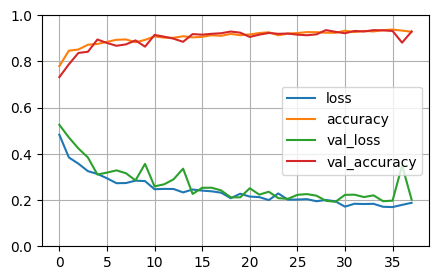

In [ ]:
## GRAFICA HISTORIAL
pd.DataFrame(history.history).plot(figsize=(5, 3))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
## MATRIZ DE COMFUSION
confu_mat = confusion_matrix(y_train, model.predict(X_train).round(0), normalize = 'pred')
sns.heatmap(confu_mat/np.sum(confu_mat,axis=1), annot=True)

In [ ]:
## GUARDAMOS MODELO
model.save("modelo-gen1.h5") 
